In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline


In [2]:
# Let's load our excel and parse per Sheet, as well i will add predict sheet 
xls = pd.ExcelFile("Data/Dataset.xlsx", on_demand = True)
sheets = xls.sheet_names
df_test_job =xls.parse('Test_Jobs')
df_job_titles = xls.parse('Test_JobTitles')
df_test_cat = xls.parse('Test_Categories')
df_predict = xls.parse('Predict').set_index('JobId')

In [3]:
# Merge Sheet "df_job_titles" with "df_test_cat"
df_job_categ = df_job_titles.set_index(['CategoryId']).join(df_test_cat.set_index(['CategoryId']))
df_job_categ

,JobTitleId,JobTitleName,CategoryName
CategoryId,,,
1,1,Receptionist,General Administration
1,2,Administrative Assistant,General Administration
1,3,Bookkeeper,General Administration
2,4,Special Education Teacher,Special Education
2,5,Special Education Assistant,Special Education
2,6,Reader Aide,Special Education
3,7,Civil Engineer,Civil Engineering
3,8,Traffic Engineer,Civil Engineering
3,9,Environmental Manager,Civil Engineering


In [4]:
df_all = df_test_job.set_index(['CategoryId','JobTitleId']).join(df_job_categ.reset_index().set_index(['CategoryId','JobTitleId']))
df_all.head()

JobId      City State  DescriptionLength  \
CategoryId JobTitleId                                             
1          1               1  New York    NY                414   
           1               2  New York    NY                199   
           1               3  New York    NY                527   
           1               4  New York    NY                132   
           1               5  New York    NY                422   

                       EducationLevel  Clicks  Applicants  JobTitleName  \
CategoryId JobTitleId                                                     
1          1                      1.0     125          24  Receptionist   
           1                      1.0      60           8  Receptionist   
           1                      1.0     159          13  Receptionist   
           1                      2.0      40           5  Receptionist   
           1                      3.0     127          11  Receptionist   

                                 CategoryName  
CategoryId JobTitleId                          
1          1           General Administration  
           1           General Administration  
           1           General Administration  
           1           General Administration  
           1           General Administration

In [5]:
#All Nulls is dataset
df_all[df_all.isnull().any(axis=1)]

JobId      City State  DescriptionLength  \
CategoryId JobTitleId                                             
1          1              13  Syracuse    NY                378   
           4             315  Syracuse    NY                311   
3          12            798    Boston    MA                700   
5          4             314  Syracuse    NY                480   

                       EducationLevel  Clicks  Applicants  JobTitleName  \
CategoryId JobTitleId                                                     
1          1                      NaN     114          11  Receptionist   
           4                      3.0      94           7           NaN   
3          12                     3.0     210          26           NaN   
5          4                      1.0     144           8           NaN   

                                 CategoryName  
CategoryId JobTitleId                          
1          1           General Administration  
           4                              NaN  
3          12                             NaN  
5          4                              NaN

In [6]:
# Percentage of Nulls in dataset per columns
total = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
CategoryName,3,0.003
JobTitleName,3,0.003
EducationLevel,1,0.001
Applicants,0,0.000
Clicks,0,0.000
DescriptionLength,0,0.000
State,0,0.000
City,0,0.000
JobId,0,0.000


# Question 2 


# Data integrity :
i need to validate data first, clean data, and only then i can answer Q1 and predict data in Q3

# Issue 1: There is no category 5 (JobID= 314)

In [7]:
df_all.query('CategoryId == 5')

,,JobId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
CategoryId,JobTitleId,,,,,,,,,
5,4,314,Syracuse,NY,480,1.0,144,8,NaN,NaN


#Handling issue 1.1 bad merge 'JobTitleName' and 'CategoryName' no such category as 5

In [8]:
df_test_job = df_test_job.set_index('JobId')

In [9]:
df_test_job.loc[314, 'CategoryId'] =df_job_titles.query('JobTitleId == %s'%df_test_job.loc[314, 'JobTitleId'])['CategoryId'].values[0]
df_test_job.loc[314].to_frame()

,314
JobTitleId,4
CategoryId,2
City,Syracuse
State,NY
DescriptionLength,480
EducationLevel,1
Clicks,144
Applicants,8


In [10]:
#regenarate df_all
df_all = df_test_job.reset_index().set_index(['CategoryId','JobTitleId']).join(df_job_categ.reset_index().set_index(['CategoryId','JobTitleId']))
df_all[df_all.isnull().any(axis=1)]

JobId      City State  DescriptionLength  \
CategoryId JobTitleId                                             
1          1              13  Syracuse    NY                378   
           4             315  Syracuse    NY                311   
3          12            798    Boston    MA                700   

                       EducationLevel  Clicks  Applicants  JobTitleName  \
CategoryId JobTitleId                                                     
1          1                      NaN     114          11  Receptionist   
           4                      3.0      94           7           NaN   
3          12                     3.0     210          26           NaN   

                                 CategoryName  
CategoryId JobTitleId                          
1          1           General Administration  
           4                              NaN  
3          12                             NaN

# Issue 2 : 	No JobTitleId = 12 , bad merge 'JobTitleName' and 'CategoryName' (JobID = 798)

In [11]:
df_all.query('CategoryId==3 and State=="MA" and EducationLevel==3 and City=="Boston"').sort_values('DescriptionLength')

JobId    City State  DescriptionLength  EducationLevel  \
CategoryId JobTitleId                                                           
3          10            995  Boston    MA                120             3.0   
           10            990  Boston    MA                141             3.0   
           7             700  Boston    MA                211             3.0   
           7             695  Boston    MA                285             3.0   
           8             799  Boston    MA                321             3.0   
           8             790  Boston    MA                324             3.0   
           9             893  Boston    MA                340             3.0   
           10            996  Boston    MA                542             3.0   
           8             796  Boston    MA                561             3.0   
           8             793  Boston    MA                564             3.0   
           8             795  Boston    MA                570             3.0   
           12            798  Boston    MA                700             3.0   
           10            999  Boston    MA                701             3.0   
           8             797  Boston    MA                803             3.0   
           7             696  Boston    MA                804             3.0   
           10            997  Boston    MA                875             3.0   
           9             897  Boston    MA                896             3.0   

                       Clicks  Applicants                  JobTitleName  \
CategoryId JobTitleId                                                     
3          10              36           5  Field Engineering Technician   
           10              43           8  Field Engineering Technician   
           7               64          12                Civil Engineer   
           7               86           6                Civil Engineer   
           8               97          10              Traffic Engineer   
           8               98          14              Traffic Engineer   
           9              102          12         Environmental Manager   
           10             163          25  Field Engineering Technician   
           8              169          14              Traffic Engineer   
           8              170          21              Traffic Engineer   
           8              171          23              Traffic Engineer   
           12             210          26                           NaN   
           10             211          17  Field Engineering Technician   
           8              241          34              Traffic Engineer   
           7              242          34                Civil Engineer   
           10             263          16  Field Engineering Technician   
           9              269          25         Environmental Manager   

                            CategoryName  
CategoryId JobTitleId                     
3          10          Civil Engineering  
           10          Civil Engineering  
           7           Civil Engineering  
           7           Civil Engineering  
           8           Civil Engineering  
           8           Civil Engineering  
           9           Civil Engineering  
           10          Civil Engineering  
           8           Civil Engineering  
           8           Civil Engineering  
           8           Civil Engineering  
           12                        NaN  
           10          Civil Engineering  
           8           Civil Engineering  
           7           Civil Engineering  
           10          Civil Engineering  
           9           Civil Engineering

#Handling issue 1.2

In [12]:
 
df_test_job = df_test_job.reset_index().set_index('JobId')
df_test_job.loc[798, 'JobTitleId'] = 10 # my best guess is that it is probably 'Field Engineering Technician'
df_test_job.loc[798] 

JobTitleId               10
CategoryId                3
City                 Boston
State                    MA
DescriptionLength       700
EducationLevel            3
Clicks                  210
Applicants               26
Name: 798, dtype: object

In [13]:
#regenarate df_all
df_all = df_test_job.reset_index().set_index(['CategoryId','JobTitleId']).join(df_job_categ.reset_index().set_index(['CategoryId','JobTitleId']))

df_all[df_all.isnull().any(axis=1)]

JobId      City State  DescriptionLength  \
CategoryId JobTitleId                                             
1          1              13  Syracuse    NY                378   
           4             315  Syracuse    NY                311   

                       EducationLevel  Clicks  Applicants  JobTitleName  \
CategoryId JobTitleId                                                     
1          1                      NaN     114          11  Receptionist   
           4                      3.0      94           7           NaN   

                                 CategoryName  
CategoryId JobTitleId                          
1          1           General Administration  
           4                              NaN

# Issue 3 : Bad combination of 'JobTitleId' and	'CategoryId' (JobID= 315)

In [14]:
df_all.query('JobId == 315') 

,,JobId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
CategoryId,JobTitleId,,,,,,,,,
1,4,315,Syracuse,NY,311,3.0,94,7,NaN,NaN


#Handling issue 1.3

In [15]:

df_all.query('JobTitleId==4 and State=="NY" and EducationLevel==3 and City=="Syracuse"').sort_values('DescriptionLength')

,,JobId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
CategoryId,JobTitleId,,,,,,,,,
1,4,315,Syracuse,NY,311,3.0,94,7,NaN,NaN
2,4,322,Syracuse,NY,537,3.0,162,23,Special Education Teacher,Special Education


In [16]:
df_test_job = df_test_job.reset_index().set_index('JobId')
df_test_job.loc[315, 'CategoryId'] = 2 # my best guess is that it is probably 'Field Engineering Technician'
df_test_job.loc[315] 

JobTitleId                  4
CategoryId                  2
City                 Syracuse
State                      NY
DescriptionLength         311
EducationLevel              3
Clicks                     94
Applicants                  7
Name: 315, dtype: object

In [17]:
#regenarate df_all
df_all = df_test_job.reset_index().set_index(['CategoryId','JobTitleId']).join(df_job_categ.reset_index().set_index(['CategoryId','JobTitleId']))

df_all[df_all.isnull().any(axis=1)]

,,JobId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
CategoryId,JobTitleId,,,,,,,,,
1,1,13,Syracuse,NY,378,NaN,114,11,Receptionist,General Administration


# Issue 4 : EducationLevel is Null (JobID= 13)

In [18]:
df_all.query('JobId == 13') 

,,JobId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
CategoryId,JobTitleId,,,,,,,,,
1,1,13,Syracuse,NY,378,NaN,114,11,Receptionist,General Administration


#Handling issue 1.4 i will use fillna to EducationLevel feature


In [19]:
df_all = df_all.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [20]:
df_all.head()

JobId      City State  DescriptionLength  \
CategoryId JobTitleId                                             
1          1               1  New York    NY                414   
           1               2  New York    NY                199   
           1               3  New York    NY                527   
           1               4  New York    NY                132   
           1               5  New York    NY                422   

                       EducationLevel  Clicks  Applicants  JobTitleName  \
CategoryId JobTitleId                                                     
1          1                      1.0     125          24  Receptionist   
           1                      1.0      60           8  Receptionist   
           1                      1.0     159          13  Receptionist   
           1                      2.0      40           5  Receptionist   
           1                      3.0     127          11  Receptionist   

                                 CategoryName  
CategoryId JobTitleId                          
1          1           General Administration  
           1           General Administration  
           1           General Administration  
           1           General Administration  
           1           General Administration

In [21]:
 df_all.isnull().sum().max() # Checking if there is any Null in the dataset 


0

In [22]:
df_all.describe()

,JobId,DescriptionLength,EducationLevel,Clicks,Applicants
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,500.291000,1.996000,160.226000,19.435000
std,288.819436,230.639673,0.802888,319.058878,11.843143
min,1.000000,100.000000,1.000000,0.000000,-5.000000
25%,250.750000,300.750000,1.000000,90.000000,10.000000
50%,500.500000,508.000000,2.000000,153.000000,17.000000
75%,750.250000,697.500000,3.000000,210.000000,27.000000
max,1000.000000,900.000000,3.000000,9999.000000,112.000000


## EDA

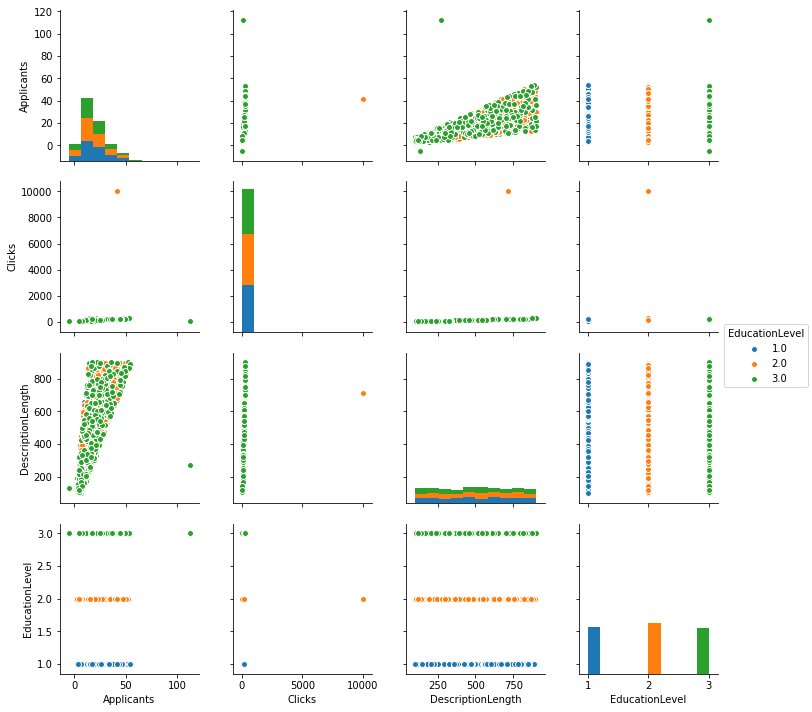

In [23]:
# Let's see corralation between features'



import seaborn as sns
df_all_eda = df_all.copy()

sns.pairplot(df_all_eda[['Applicants','Clicks','DescriptionLength','EducationLevel']], hue='EducationLevel')

We can see that there are a few outliers , let's drop them from dataset

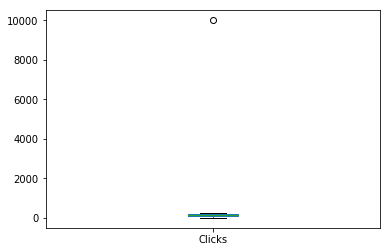

In [24]:
# let's see Clicks in a boxplot 
df_all.Clicks.plot.box()

In [25]:
#we can see a few outliers , let's drop them from dataset 

bad_data_query ='Applicants <= 0 or Clicks <=0 or EducationLevel<=0 or DescriptionLength <=0 or DescriptionLength <=0\
or Applicants > Clicks or City == "" or State =="" or Clicks >9000'
simple_data_anomalies = df_all.query(bad_data_query)
simple_data_anomalies

JobId         City State  DescriptionLength  \
CategoryId JobTitleId                                                
1          2             116     Syracuse    NY                132   
           3             256  Los Angeles    CA                269   
2          5             412     Syracuse    NY                323   
3          10            981  Newtonville    MA                714   

                       EducationLevel  Clicks  Applicants  \
CategoryId JobTitleId                                       
1          2                      3.0      40          -5   
           3                      3.0      81         112   
2          5                      1.0       0          18   
3          10                     2.0    9999          41   

                                       JobTitleName            CategoryName  
CategoryId JobTitleId                                                        
1          2               Administrative Assistant  General Administration  
           3                             Bookkeeper  General Administration  
2          5            Special Education Assistant       Special Education  
3          10          Field Engineering Technician       Civil Engineering

In [26]:
# deleting all rows with bad data

z = df_all.reset_index().set_index('JobId')
df_all = z.loc[~z.index.isin(simple_data_anomalies.set_index('JobId').index)]

# City Anomalies


#9 Issue - "New York" & "New-York" several versions
#10 Issue - "New York" wrong city state combination


In [27]:
# i am checking uniqueness in City and State


df_city = df_all[['City','State']].apply(lambda r:r[0]+'-'+r[1],axis = 1).unique()
df_city

array([u'New York-NY', u'Syracuse-NY', u'Binghamton-NY', u'Sacramento-CA',
       u'Lodi-CA', u'Los Angeles-CA', u'West Newton-MA',
       u'Newtonville-MA', u'Boston-MA', u'New York-NJ', u'New-York-NY'],
      dtype=object)

In [28]:
#Handling 9 Issue - "New York" & "New-York" several versions


df_all.query('City =="New-York"')
df_all = df_all.replace({'New-York':'New York'}) # fixed

In [29]:
# Handling 10 Issue - "New York" wrong city combination


df_all.query('City =="New York" and State =="NJ"')

,CategoryId,JobTitleId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants,JobTitleName,CategoryName
JobId,,,,,,,,,,
201,1,3,New York,NJ,765,3.0,230,30,Bookkeeper,General Administration


In [30]:
df_all = df_all.reset_index().set_index('JobId')
df_all.loc[201, 'State'] = "NY" # we will replace the Clicks rate (0) to average of Clicks in this JobTitleID
df_all.loc[201] 

CategoryId                                1
JobTitleId                                3
City                               New York
State                                    NY
DescriptionLength                       765
EducationLevel                            3
Clicks                                  230
Applicants                               30
JobTitleName                     Bookkeeper
CategoryName         General Administration
Name: 201, dtype: object


# Question 1

In [31]:
max_length = df_all.query('State !="NY"').DescriptionLength.max()
long_desc = df_all.query('State !="NY" and DescriptionLength==%s'%max_length).JobTitleName.values[0]
print "The longest description outside of the state of NY is" + ' ' +long_desc
print "And it is only One"

The longest description outside of the state of NY is Special Education Teacher
And it is only One


In [32]:
name,clicks = df_all.groupby(['JobTitleName'])['Clicks'].mean().sort_values(ascending=False).reset_index().iloc[0].values
print "The highest number of average clicks is" , clicks, "and the Job Title is \"",name,"\""

The highest number of average clicks is 167.8 and the Job Title is " Environmental Manager "


In [33]:
z= df_all.groupby(['CategoryId'])[['Applicants','Clicks']].sum()
z = (z['Applicants']/z['Clicks']).sort_values(ascending=False)
cat_id,conv_rate = z.reset_index().iloc[0].values

In [34]:
high_cat = df_test_cat.query('CategoryId ==%s'%cat_id).CategoryName.values[0]
print "The Category name which has the highest conversion rate is \"", high_cat ,"\"" ,"and highest conversion rate is:",conv_rate

The Category name which has the highest conversion rate is " Special Education " and highest conversion rate is: 0.1316875196197139


## EDA before prediction

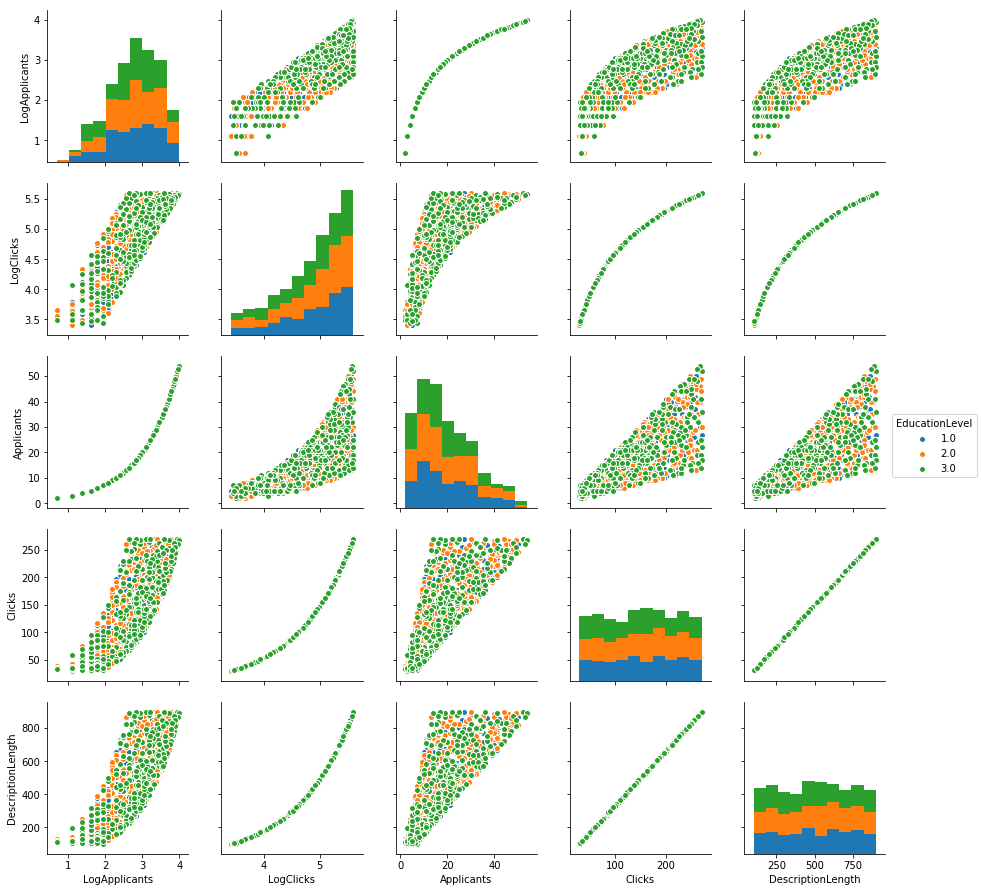

In [35]:
import seaborn as sns
df_all_eda = df_all.copy()
df_all_eda['LogApplicants'] = df_all_eda['Applicants'].apply(np.log)
df_all_eda['LogClicks'] = df_all_eda['Clicks'].apply(np.log)

pplot_vars = ['LogApplicants','LogClicks','Applicants','Clicks','DescriptionLength']
pplot_hue = 'EducationLevel'
sns.pairplot(df_all_eda[pplot_vars+[pplot_hue]], vars=pplot_vars, hue=pplot_hue)

In [36]:
# EDA
# Clicks-DescriptionLen are highly and linearly correlated, easy prediction
# Applicants-Clicks are correlated but non-linearly, and EducationLevel does not seem to help, predicting the log of it

# Question 3



# Predict Clicks

In [37]:
# jobid not useful for prediction and i want to manipulate features together with the data required to predict
df_model = pd.concat([df_predict, df_all]) 
df_model.head() 

c:\miniconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


,Applicants,CategoryId,CategoryName,City,Clicks,DescriptionLength,EducationLevel,JobTitleId,JobTitleName,State
JobId,,,,,,,,,,
1001,NaN,1,NaN,New York,NaN,314,2.0,1,NaN,NY
1002,NaN,4,NaN,New York,NaN,199,1.0,11,NaN,NY
1,24.0,1,General Administration,New York,125.0,414,1.0,1,Receptionist,NY
2,8.0,1,General Administration,New York,60.0,199,1.0,1,Receptionist,NY
3,13.0,1,General Administration,New York,159.0,527,1.0,1,Receptionist,NY


In [38]:
#using only relevant columns

col_features = ['DescriptionLength', 'CategoryId','JobTitleId','City','State','EducationLevel']
df_features = pd.get_dummies(df_model[col_features])
df_features.head()

,DescriptionLength,CategoryId,JobTitleId,EducationLevel,City_Binghamton,City_Boston,City_Lodi,City_Los Angeles,City_New York,City_Newtonville,City_Sacramento,City_Syracuse,City_West Newton,State_CA,State_MA,State_NY
JobId,,,,,,,,,,,,,,,,
1001,314,1,1,2.0,0,0,0,0,1,0,0,0,0,0,0,1
1002,199,4,11,1.0,0,0,0,0,1,0,0,0,0,0,0,1
1,414,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1
2,199,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1
3,527,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1


In [39]:
# extracting my target rows


df_predict_to_model = df_features.loc[df_predict.index]
df_predict_to_model

,DescriptionLength,CategoryId,JobTitleId,EducationLevel,City_Binghamton,City_Boston,City_Lodi,City_Los Angeles,City_New York,City_Newtonville,City_Sacramento,City_Syracuse,City_West Newton,State_CA,State_MA,State_NY
JobId,,,,,,,,,,,,,,,,
1001,314,1,1,2.0,0,0,0,0,1,0,0,0,0,0,0,1
1002,199,4,11,1.0,0,0,0,0,1,0,0,0,0,0,0,1


In [40]:
# leaving only relevant data for training


df_features = df_features.loc[~df_features.index.isin(df_predict_to_model.index)]
df_features.head()

,DescriptionLength,CategoryId,JobTitleId,EducationLevel,City_Binghamton,City_Boston,City_Lodi,City_Los Angeles,City_New York,City_Newtonville,City_Sacramento,City_Syracuse,City_West Newton,State_CA,State_MA,State_NY
JobId,,,,,,,,,,,,,,,,
1,414,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1
2,199,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1
3,527,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,1
4,132,1,1,2.0,0,0,0,0,1,0,0,0,0,0,0,1
5,422,1,1,3.0,0,0,0,0,1,0,0,0,0,0,0,1


In [41]:
train_test_split

# Prediction with XGBoost model

In [42]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, Y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_test, Y_test, feature_names=X_test.columns.values)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'seed' : 7,
    'booster' : 'dart'
}

[0]	train-rmse:159.81	test-rmse:159.789
[50]	train-rmse:13.0971	test-rmse:13.0997
[100]	train-rmse:1.14923	test-rmse:1.23567
[150]	train-rmse:0.236582	test-rmse:0.573222
[199]	train-rmse:0.169864	test-rmse:0.565421


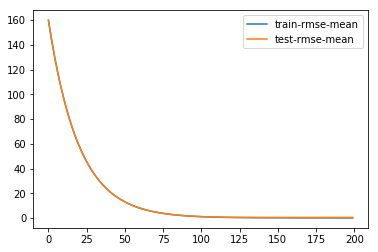

In [43]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=200, early_stopping_rounds=25, verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [44]:
cv_output.tail(10)

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
190,0.565252,0.023009,0.177469,0.005679
191,0.565351,0.023070,0.176914,0.005791
192,0.565471,0.022944,0.176099,0.005651
193,0.565522,0.022713,0.175346,0.005693
194,0.565362,0.022488,0.174425,0.005481
195,0.565644,0.022975,0.173373,0.005253
196,0.565548,0.023182,0.172489,0.005395
197,0.565547,0.023338,0.171563,0.005293
198,0.565360,0.023307,0.170648,0.005111
199,0.565421,0.023205,0.169864,0.005166


In [45]:
num_boost_rounds = len(cv_output)
model_clk = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

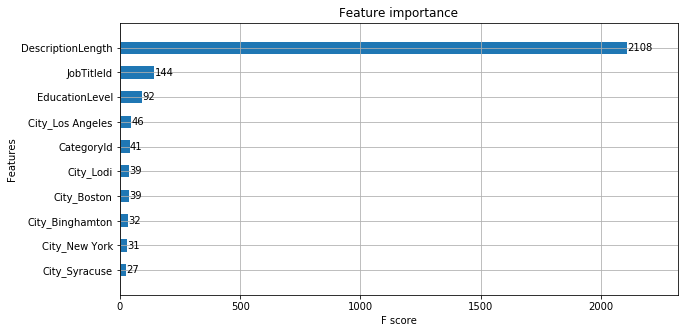

In [46]:
# Feature Importance 

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
xgb.plot_importance(model_clk, max_num_features=10, height=0.5, ax=ax)

In [47]:
Y_test_tag = model_clk.predict(xgb.DMatrix(X_test, feature_names=X_test.columns.values))
print 'RMSE of Clicks model',np.sqrt(np.sum((Y_test-Y_test_tag)**2))

RMSE of Clicks model 7.824438796989919


In [48]:
#i am using chaining, because  clicks are converted into applicants
Y_predict = model_clk.predict(xgb.DMatrix(df_predict_to_model, feature_names=df_predict_to_model.columns.values))
print 'Clicks Prediction is :', Y_predict,'for JobIds',df_predict_to_model.index.values
df_predict['Clicks'] = Y_predict
df_predict

Clicks Prediction is : [94.2426   59.947586] for JobIds [1001 1002]


,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks
JobId,,,,,,,
1001,1,1,New York,NY,314,2,94.242599
1002,11,4,New York,NY,199,1,59.947586


# Predict Applicants

In [49]:
X_train_app = X_train.join(df_model['Clicks'])
X_test_app = X_test.join(df_model['Clicks'])
Y_train_app = df_model['Applicants'].loc[X_train_app.index]
Y_test_app = df_model['Applicants'].loc[X_test_app.index]

df_predict_to_model['Clicks'] = Y_predict
features_for_app = df_predict_to_model.columns.values
df_predict_to_model

,DescriptionLength,CategoryId,JobTitleId,EducationLevel,City_Binghamton,City_Boston,City_Lodi,City_Los Angeles,City_New York,City_Newtonville,City_Sacramento,City_Syracuse,City_West Newton,State_CA,State_MA,State_NY,Clicks
JobId,,,,,,,,,,,,,,,,,
1001,314,1,1,2.0,0,0,0,0,1,0,0,0,0,0,0,1,94.242599
1002,199,4,11,1.0,0,0,0,0,1,0,0,0,0,0,0,1,59.947586


In [50]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_app, Y_train_app, feature_names=X_train_app.columns.values)
dtest = xgb.DMatrix(X_test_app, Y_test_app, feature_names=X_test_app.columns.values)
print 'Training with',X_train_app.columns.values

xgb_params =  {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'seed' : 7,
     'booster' : 'dart'
}

Training with [u'DescriptionLength' u'CategoryId' u'JobTitleId' u'EducationLevel'
 u'City_Binghamton' u'City_Boston' u'City_Lodi' u'City_Los Angeles'
 u'City_New York' u'City_Newtonville' u'City_Sacramento' u'City_Syracuse'
 u'City_West Newton' u'State_CA' u'State_MA' u'State_NY' u'Clicks']


[0]	train-rmse:21.7464	test-rmse:21.7464
[50]	train-rmse:5.85629	test-rmse:8.03493
[99]	train-rmse:4.56651	test-rmse:8.05339


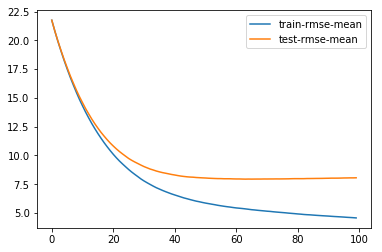

In [51]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=100, early_stopping_rounds=50, verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [52]:
cv_output.tail(10)

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
90,8.014734,0.181902,4.725434,0.172413
91,8.022372,0.176437,4.705201,0.170058
92,8.021867,0.179393,4.686987,0.171503
93,8.023414,0.176985,4.672403,0.174439
94,8.029019,0.178729,4.656275,0.177849
95,8.037879,0.176056,4.638988,0.177935
96,8.040573,0.176193,4.618855,0.178275
97,8.046973,0.177659,4.603453,0.172947
98,8.046509,0.177927,4.586833,0.171559
99,8.053387,0.180618,4.566509,0.168060


In [53]:
num_boost_rounds = len(cv_output)
model_app = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

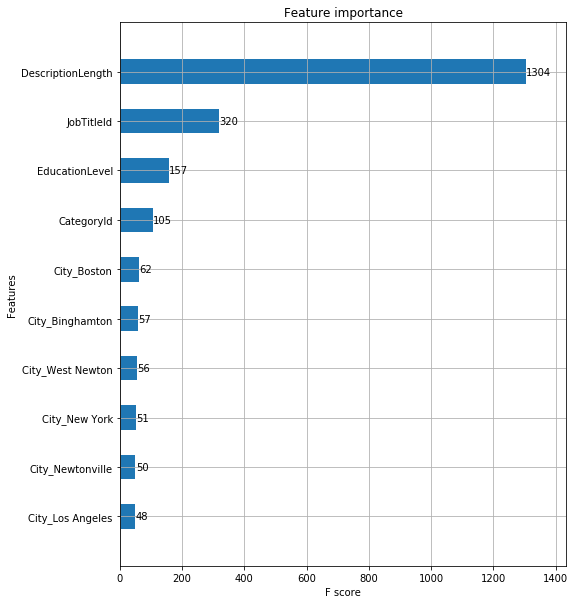

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
xgb.plot_importance(model_app, max_num_features=10, height=0.5, ax=ax)

In [55]:
Y_test_app_tag = model_app.predict(xgb.DMatrix(X_test_app, feature_names=X_test_app.columns.values))
print 'RMSE of Applicants model',np.sqrt(np.sum((Y_test_app-Y_test_app_tag)**2)),' this can be improved by predicting the log of Applicants'

RMSE of Applicants model 133.2740583115195  this can be improved by predicting the log of Applicants


In [56]:
Y_predict = model_app.predict(xgb.DMatrix(df_predict_to_model, feature_names=df_predict_to_model.columns.values))
print 'Applicants Prediction is :', Y_predict,'for JobIds',df_predict_to_model.index.values
df_predict['Applicants'] = Y_predict
df_predict

Applicants Prediction is : [10.994752   7.2963934] for JobIds [1001 1002]


,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
JobId,,,,,,,,
1001,1,1,New York,NY,314,2,94.242599,10.994752
1002,11,4,New York,NY,199,1,59.947586,7.296393


## Question 3.2 How I estimate the prediction? 

In [57]:
# The prediction capability of the models was estimated using RMSE, measured in the units of the predicted variable. 
# Each need will decide if a size of the RMSE is okay, like  

c:\miniconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


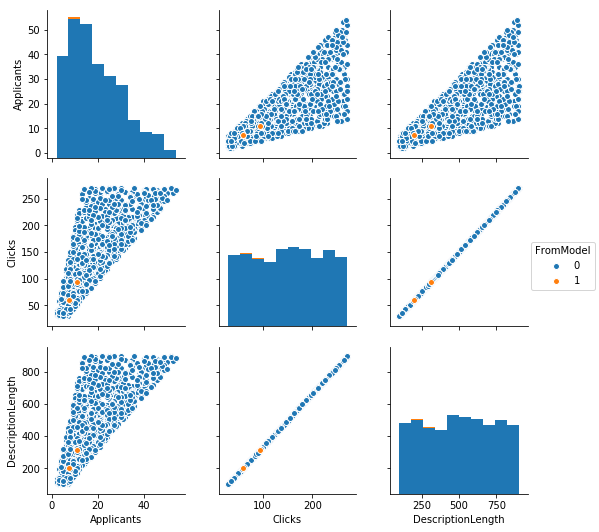

In [58]:
df_all['FromModel'] = 0
df_predict['FromModel'] = 1
pplot_vars = ['Applicants','Clicks','DescriptionLength']
pplot_hue = 'FromModel'
sns.pairplot(pd.concat([df_predict, df_all])[pplot_vars+[pplot_hue]], vars=pplot_vars,hue=pplot_hue)